In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import compress
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import os

parentDirectory = os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir))
DATA_DIR = parentDirectory +'/data/'
FIGURES_DIR = parentDirectory +'/figures/'

df_agg = pd.read_pickle(DATA_DIR+'df_agg_cats.pickle')
df_mobility = pd.read_csv(DATA_DIR+'df_mobility.csv')

full_names = {
    'AU': 'Australia',
    'BR': 'Brazil',
    'CA': 'Canada',
    'FR': 'France',
    'DE': 'Germany',
    'IN': 'India',
    'IT': 'Italy',
    'MX': 'Mexico',
    'ES': 'Spain',
    'GB': 'United Kingdom',
    'US': 'United States',
    'DK': 'Denmark'
}

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

event_dicts = [{'country': 'AU',
  'start_md_1': '2020-03-27',
  'end_md_1': '2020-06-07',
  'start_md_2': np.nan},
 {'country': 'BR',
  'start_md_1': '2020-03-23',
  'end_md_1': '2020-08-09',
  'start_md_2': np.nan},
 {'country': 'CA',
  'start_md_1': '2020-03-19',
  'end_md_1': '2020-06-21',
  'start_md_2': '2020-10-12'},
 {'country': 'DE',
  'start_md_1': '2020-03-21',
  'end_md_1': '2020-05-09',
  'start_md_2': '2020-12-18'},
 {'country': 'DK',
  'start_md_1': '2020-03-17',
  'end_md_1': '2020-05-07',
  'start_md_2': np.nan},
 {'country': 'ES',
  'start_md_1': '2020-03-17',
  'end_md_1': '2020-06-14',
  'start_md_2': '2020-11-07'},
 {'country': 'FR',
  'start_md_1': '2020-03-18',
  'end_md_1': '2020-06-08',
  'start_md_2': '2020-11-01'},
 {'country': 'GB',
  'start_md_1': '2020-03-23',
  'end_md_1': '2020-08-03',
  'start_md_2': '2020-10-21'},
 {'country': 'IN',
  'start_md_1': '2020-03-24',
  'end_md_1': '2020-10-29',
  'start_md_2': np.nan},
 {'country': 'IT',
  'start_md_1': '2020-03-11',
  'end_md_1': '2020-06-06',
  'start_md_2': '2020-11-06'},
 {'country': 'JP',
  'start_md_1': '2020-04-12',
  'end_md_1': '2020-05-30',
  'start_md_2': np.nan},
 {'country': 'KE',
  'start_md_1': '2020-03-24',
  'end_md_1': '2020-10-04',
  'start_md_2': np.nan},
 {'country': 'MX',
  'start_md_1': '2020-03-25',
  'end_md_1': '2020-10-06',
  'start_md_2': np.nan},
 {'country': 'NG',
  'start_md_1': '2020-03-27',
  'end_md_1': '2020-08-09',
  'start_md_2': np.nan},
 {'country': 'US',
  'start_md_1': '2020-03-21',
  'end_md_1': '2020-06-11',
  'start_md_2': '2020-11-26'}]

df_events = pd.DataFrame(event_dicts)
df_events['start_md_1'] = pd.to_datetime(df_events['start_md_1'])
df_events['end_md_1'] = pd.to_datetime(df_events['end_md_1'])
df_events['start_md_2'] = pd.to_datetime(df_events['start_md_2'])

In [2]:
df_agg = df_agg.loc[df_agg['country'].isin(full_names.keys())]
studied_weeks = list(df_agg.iloc[0]['volume_weekly_total'].index)[-46:]

mobility_ts = {}

for country, gr in df_mobility.groupby('country_region_code'):
    mobility_dict = {}
    gr = gr.iloc[1:323]
    for i in chunker(gr,7):
        mobility_dict[i.iloc[0]['date']] = (i['residential_percent_change_from_baseline'].mean())
    mobility_ts[country] = mobility_dict

In [3]:
entry_list_first_wave = []
entry_list_second_wave = []

for category, gr1 in df_agg.groupby('category'):
    #print(category)
    for country, gr2 in gr1.groupby('country'):
        entry = {}
        #print(country)
        
        x = gr2['volume_weekly_total'].values[0][-46:]
        y = mobility_ts[country]

        mask = (pd.to_datetime(x.index)<=df_events.loc[df_events['country']==country]['end_md_1'].iloc[0])

        entry['category'] = category
        entry['corr'] = spearmanr(x.values, list(y.values()))[0]
        entry['p'] = spearmanr(x.values, list(y.values()))[1]
        
        entry['country'] = country
        
        entry_list_first_wave.append(entry.copy())

df_plot_w_1 = pd.DataFrame(entry_list_first_wave)

In [4]:
df_plot_w_1['wave'] = ['First wave']*len(df_plot_w_1)

order = list(df_plot_w_1.groupby('category').agg('mean').sort_values(by = 'corr').index[::-1])

temp_df1 = pd.DataFrame({'category': order, 
                        'category_id':2*np.array(range(len(order)))})

df_plot_w_1_a = df_plot_w_1.merge(temp_df1, on='category', how='left')

df_plot_w_1_a['category_id'] = df_plot_w_1_a['category_id'].astype(int)


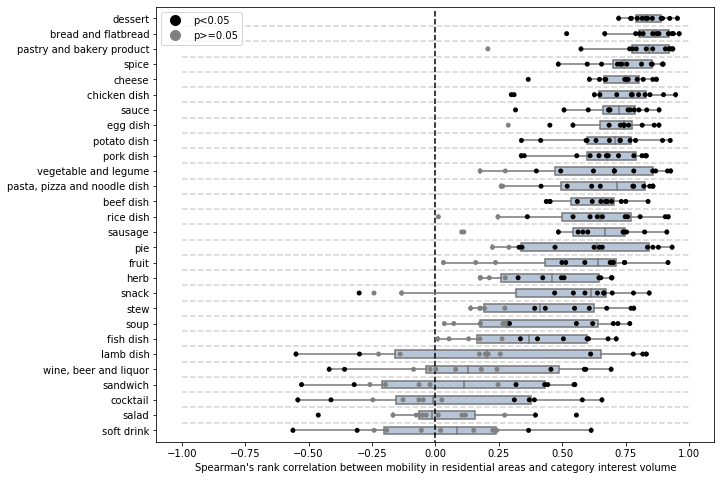

In [6]:
df_plot_w_1_a['p<0.05'] = df_plot_w_1_a['p'].apply(lambda x: 'p<0.05' if x <0.05 else 'p>=0.05')

f, ax = plt.subplots(figsize=(10,8))


sns.boxplot(x="corr", y="category_id", data=df_plot_w_1_a, orient = 'h',  width = 1,
            color = 'lightsteelblue', order=np.arange(2*29), showfliers=False)

red_patch = mpatches.Patch(color='darksalmon', label='First wave')
blue_patch = mpatches.Patch(color='lightsteelblue', label='Second wave')


sc1 = Line2D([0], [0], marker='o', color='black', label='p<0.05', linestyle = 'None',
                          markerfacecolor='black', markersize=10)
sc2 = Line2D([0], [0], marker='o', color='gray', label='p>=0.05', linestyle = 'None',
                          markerfacecolor='gray', markersize=10)


#plt.legend(handles=[red_patch, blue_patch])

sns.stripplot(x="corr", y="category_id", hue = 'p<0.05',data=df_plot_w_1_a, orient = 'h',
            size = 5, palette=['black','gray'], order=np.arange(2*29), jitter = 0)


plt.legend(handles=[sc1, sc2])



for i in range(1,27*2)[::2]:
    plt.hlines(i,-1,1,linestyle ='--',color = 'lightgray')
            
             #width=0.5

plt.yticks(np.arange(2*29)[::2], order);
plt.ylim([28*2-0.5, -1.50])
plt.vlines(0,-1,56, linestyle = '--',color = 'black')
plt.ylabel('')
plt.xlabel("Spearman's rank correlation between mobility in residential areas and category interest volume");

plt.savefig(FIGURES_DIR+"corr_two_waves.pdf", bbox_inches='tight')

In [7]:
entry_list_first_wave = []
entry_list_second_wave = []

for category, gr1 in df_agg.groupby('category'):
    #print(category)
    for country, gr2 in gr1.groupby('country'):
        entry = {}
        #print(country)
        
        x = gr2['volume_weekly_total'].values[0][-46:]
        y = mobility_ts[country]

        mask = (pd.to_datetime(x.index)<=df_events.loc[df_events['country']==country]['end_md_1'].iloc[0])

        entry['category'] = category
        entry['corr'] = pearsonr(x.values, list(y.values()))[0]
        entry['p'] = pearsonr(x.values, list(y.values()))[1]
        
        entry['country'] = country
        
        entry_list_first_wave.append(entry.copy())

df_plot_w_1 = pd.DataFrame(entry_list_first_wave)

df_plot_w_1['wave'] = ['First wave']*len(df_plot_w_1)

order = list(df_plot_w_1.groupby('category').agg('mean').sort_values(by = 'corr').index[::-1])

temp_df1 = pd.DataFrame({'category': order, 
                        'category_id':2*np.array(range(len(order)))})

df_plot_w_1_a = df_plot_w_1.merge(temp_df1, on='category', how='left')

df_plot_w_1_a['category_id'] = df_plot_w_1_a['category_id'].astype(int)


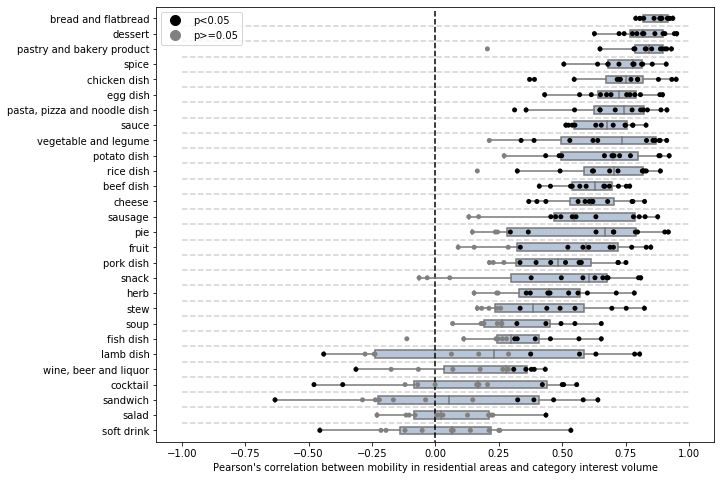

In [9]:
df_plot_w_1_a['p<0.05'] = df_plot_w_1_a['p'].apply(lambda x: 'p<0.05' if x <0.05 else 'p>=0.05')

f, ax = plt.subplots(figsize=(10,8))


sns.boxplot(x="corr", y="category_id", data=df_plot_w_1_a, orient = 'h',  width = 1,
            color = 'lightsteelblue', order=np.arange(2*29), showfliers=False)

red_patch = mpatches.Patch(color='darksalmon', label='First wave')
blue_patch = mpatches.Patch(color='lightsteelblue', label='Second wave')


sc1 = Line2D([0], [0], marker='o', color='black', label='p<0.05', linestyle = 'None',
                          markerfacecolor='black', markersize=10)
sc2 = Line2D([0], [0], marker='o', color='gray', label='p>=0.05', linestyle = 'None',
                          markerfacecolor='gray', markersize=10)


#plt.legend(handles=[red_patch, blue_patch])

sns.stripplot(x="corr", y="category_id", hue = 'p<0.05',data=df_plot_w_1_a, orient = 'h',
            size = 5, palette=['black','gray'], order=np.arange(2*29), jitter = 0)


plt.legend(handles=[sc1, sc2])



for i in range(1,27*2)[::2]:
    plt.hlines(i,-1,1,linestyle ='--',color = 'lightgray')
            
             #width=0.5

plt.yticks(np.arange(2*29)[::2], order);
plt.ylim([28*2-0.5, -1.50])
plt.vlines(0,-1,56, linestyle = '--',color = 'black')
plt.ylabel('')
plt.xlabel("Pearson's correlation between mobility in residential areas and category interest volume");

plt.savefig(FIGURES_DIR+"appendix_pearson_cats.pdf", bbox_inches='tight')

In [6]:
entry_list_first_wave = []
entry_list_second_wave = []

for category, gr1 in df_agg.groupby('category'):
    
    #print(category)
    for country, gr2 in gr1.groupby('country'):
        entry = {}
        #print(country)
        
        x = gr2['volume_weekly_total'].values[0][-46:]
        y = mobility_ts[country]

        mask = (pd.to_datetime(x.index)<=df_events.loc[df_events['country']==country]['end_md_1'].iloc[0])        

        x = x.loc[mask]
        y = list(compress(list(y.values()),mask))
        
        entry['category'] = category
        entry['corr'] = pearsonr(x.values, y)[0]
        entry['p'] = pearsonr(x.values, y)[1]
        
        entry['country'] = country
        
        entry_list_first_wave.append(entry.copy())
        
        
        
        
        
        x = gr2['volume_weekly_total'].values[0][-46:]
        y = mobility_ts[country]

        mask = (pd.to_datetime(x.index)>df_events.loc[df_events['country']==country]['end_md_1'].iloc[0])
        
        x = x.loc[mask]
        y = list(compress(list(y.values()),mask))
        
        entry['corr'] = pearsonr(x.values, y)[0]
        entry['p'] = pearsonr(x.values, y)[1]
        
        entry_list_second_wave.append(entry)
        
    #print('\n')


df_plot_w_1 = pd.DataFrame(entry_list_first_wave)
df_plot_w_2 = pd.DataFrame(entry_list_second_wave)

In [7]:
df_plot_w_1['wave'] = ['First wave']*len(df_plot_w_1)
df_plot_w_2['wave'] = ['Second wave']*len(df_plot_w_2)

order = list(df_plot_w_1.groupby('category').agg('median').sort_values(by = 'corr').index[::-1])

temp_df1 = pd.DataFrame({'category': order, 
                        'category_id':2*np.array(range(len(order)))})
temp_df2 = pd.DataFrame({'category': order, 
                        'category_id':2*np.array(range(len(order)))+1})

df_plot_w_1_a = df_plot_w_1.merge(temp_df1, on='category', how='left')
df_plot_w_2_a = df_plot_w_2.merge(temp_df2, on='category', how='left')

df_plot_w_1_a['category_id'] = df_plot_w_1_a['category_id'].astype(int)
df_plot_w_2_a['category_id'] = df_plot_w_2_a['category_id'].astype(int)

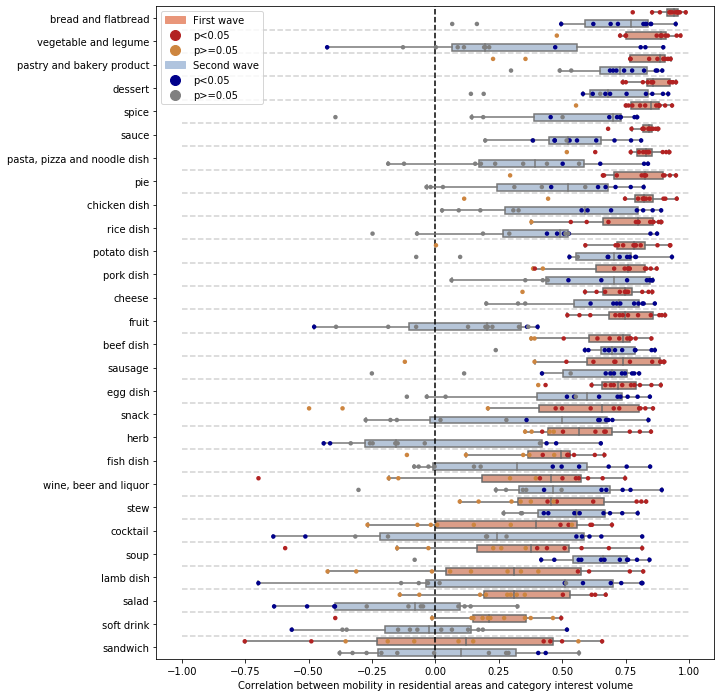

In [8]:
df_plot_w_1_a['p<0.05'] = df_plot_w_1_a['p'].apply(lambda x: 'p<0.05' if x <0.05 else 'p>=0.05')
df_plot_w_2_a['p<0.05'] = df_plot_w_2_a['p'].apply(lambda x: 'p<0.05' if x <0.05 else 'p>=0.05')

f, ax = plt.subplots(figsize=(10,12))

sns.boxplot(x="corr", y="category_id", data=df_plot_w_2_a, orient = 'h', width = 0.6,
            palette=['lightsteelblue'],order=np.arange(2*29), showfliers=False)

sns.boxplot(x="corr", y="category_id", data=df_plot_w_1_a, orient = 'h',  width = 0.6,
            palette=['darksalmon'],order=np.arange(2*29), showfliers=False)

red_patch = mpatches.Patch(color='darksalmon', label='First wave')
blue_patch = mpatches.Patch(color='lightsteelblue', label='Second wave')

sc1 = Line2D([0], [0], marker='o', color='darkblue', label='p<0.05', linestyle = 'None',
                          markerfacecolor='darkblue', markersize=10)
sc2 = Line2D([0], [0], marker='o', color='firebrick', label='p<0.05', linestyle = 'None',
                          markerfacecolor='firebrick', markersize=10)
sc3 = Line2D([0], [0], marker='o', color='gray', label='p>=0.05', linestyle = 'None',
                          markerfacecolor='gray', markersize=10)
sc4 = Line2D([0], [0], marker='o', color='peru', label='p>=0.05', linestyle = 'None',
                          markerfacecolor='peru', markersize=10)

#plt.legend(handles=[red_patch, blue_patch])

sns.stripplot(x="corr", y="category_id", hue = 'p<0.05',data=df_plot_w_2_a, orient = 'h',
            size= 4.5, palette=['darkblue','gray'],order=np.arange(2*29), jitter = 0)

sns.stripplot(x="corr", y="category_id", hue = 'p<0.05',data=df_plot_w_1_a, orient = 'h',
            size = 4.5, palette=['firebrick','peru'], order=np.arange(2*29), jitter = 0)


plt.legend(handles=[red_patch, sc2, sc4, blue_patch,sc1, sc3,])



for i in range(1,27*2)[::2]:
    plt.hlines(i+0.5,-1,1,linestyle ='--',color = 'lightgray')
            
             #width=0.5

plt.yticks(np.arange(2*29)[::2]+0.5, order);
plt.ylim([28*2-0.5, -.50])
plt.vlines(0,-1,56, linestyle = '--',color = 'black')
plt.ylabel('')
plt.xlabel("Correlation between mobility in residential areas and category interest volume");

plt.savefig(FIGURES_DIR+"corr_cats.pdf", bbox_inches='tight')